# SD201 : MINING OF LARGE DATASETS

## MUSIC GENRE CLASSIFICATION USING SONG LYRICS

In [157]:
# initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

### 1. CONSTRUCTION OF THE DATASET

The source of the dataset is a csv file : a result of a scrapping work through [GENIUS](https://genius.com/).

#### 1.1 ROW DATA EXPLORATION

In [158]:
# loading the dataset from csv file
data = pd.read_csv("lyrics.csv", sep='#')

In [159]:
# columns of dataset
data.columns

Index(['artist', 'title', 'lyrics', 'genre', 'url'], dtype='object')

In [160]:
# inspecting the content of the dataset
data.head()

,artist,title,lyrics,genre,url
0,Eminem,Rap God,"Rap God Lyrics\r\n""Look, I was gonna go easy o...",rap,https://genius.com/Eminem-rap-god-lyrics
1,Cardi B,WAP,WAP Lyrics\r\nWhores in this house\r\nThere's ...,rap,https://genius.com/Cardi-b-wap-lyrics
2,Kendrick Lamar,HUMBLE.,HUMBLE. Lyrics\r\nNobody pray for me\r\nIt bee...,rap,https://genius.com/Kendrick-lamar-humble-lyrics
3,Migos,Bad and Boujee,"Bad and Boujee Lyrics\r\nYou know, young rich ...",rap,https://genius.com/Migos-bad-and-boujee-lyrics
4,Drake,God's Plan,God’s Plan Lyrics\r\nAnd they wishin' and wish...,rap,https://genius.com/Drake-gods-plan-lyrics


In [161]:
# size of the dataset
data.shape

(6858, 5)

In [162]:
# types of data 
data.dtypes

artist    object
title     object
lyrics    object
genre     object
url       object
dtype: object

#### 1.2 ROW DATA CLEANING

In [163]:
#Missing values
data.isna().sum()[data.isna().sum() > 0]

lyrics    25
dtype: int64

In [164]:
# Deleting rows with missing values
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [165]:
#Check missing values (check is dropping went right)
data.isna().sum()


artist    0
title     0
lyrics    0
genre     0
url       0
dtype: int64

In [166]:
#deleting the "[title]-Lyrics" from the beginning of each lyrics and "[number xxx]Embed" from the end

for i in range(0,len(data['lyrics'])):
    if(re.findall(r'\d+.*Embed.*', data['lyrics'][i])!=[]):
        data['lyrics'][i] = data['lyrics'][i].split(re.findall(r'\d+.*Embed.*', data['lyrics'][i])[0])[0]

    if (re.findall(r'\bLyrics\b', data['lyrics'][i])!=[]):
        data['lyrics'][i] = data['lyrics'][i].split('Lyrics')[1]
    data['lyrics'][i] = data['lyrics'][i].lower()

In [167]:
#Checking the data cleaning on a random song lyrics
print(data['lyrics'][1])


whores in this house
there's some whores in this house
there's some whores in this house
there's some whores in this house (hol' up)
i said certified freak, seven days a week
wet-ass pussy, make that pullout game weak, woo (ah)

yeah, yeah, yeah, yeah
yeah, you fuckin' with some wet-ass pussy
bring a bucket and a mop for this wet-ass pussy
give me everything you got for this wet-ass pussy

beat it up, nigga, catch a charge
extra large and extra hard
put this pussy right in your face
swipe your nose like a credit card
hop on top, i wanna ride
i do a kegel while it's inside
spit in my mouth, look in my eyes
this pussy is wet, come take a dive
tie me up like i'm surprised
let's roleplay, i'll wear a disguise
i want you to park that big mack truck right in this little garage
make it cream, make me scream
out in public, make a scene
i don't cook, i don't clean
but let me tell you how i got this ring (ayy, ayy)
you might also like
gobble me, swallow me, drip down the side of me (yeah)
quick

In [168]:

"""
THIS LIST HAS TO BE UPDATED : TOO MUCH WORDS



# stopwords source : https://gist.github.com/sebleier/554280
stopwords = ["'d","'m","'s","'ve","'re","'ll",
             "0o", "0s", "3a", "3b", "3d", "6b", "6o", 
             "a", "a1", "a2", "a3", "a4","ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az",
             "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", 
             "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", 
             "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", 
             "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", 
             "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", 
             "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gon" , "gonna" , "gone", "got", "gotten", "gr", "greetings", "gs", "gy", 
             "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", 
             "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", 
             "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", 
             "l", "l2", "la","ll","largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", 
             "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", 
             "n", "n't", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", 
             "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", 
             "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", 
             "q", "qj", "qu", "que", "quickly", "quite", "qv", 
             "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", 
             "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", 
             "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there","there's", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", 
             "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", 
             "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", 
             "w", "wa", "want", "wanna" , "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", 
             "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", 
             "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", 
             "z", "zero", "zi", "zz",]

#Recunstructing lyrics of the chosen tokens
tokens_list = []
for i in range(len(data.lyrics)):
    tokens = ''
    tokens = word_tokenize(data.lyrics[i].lower())
    cleaned_tokens = ''
    cleaned_tokens = [token for token in tokens if token not in stopwords and token not in punctuation]
    data['lyrics'][i] = (" ".join(cleaned_tokens)).replace("`","").replace("''","")
"""

'\nTHIS LIST HAS TO BE UPDATED : TOO MUCH WORDS\n\n\n\n# stopwords source : https://gist.github.com/sebleier/554280\nstopwords = ["\'d","\'m","\'s","\'ve","\'re","\'ll",\n             "0o", "0s", "3a", "3b", "3d", "6b", "6o", \n             "a", "a1", "a2", "a3", "a4","ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain\'t", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren\'t", "arise", "around", "as", "a\'s", "aside", "ask", "askin

In [181]:
# Removing punctuation and stopwords from lyrics

from nltk import word_tokenize

from nltk.corpus import stopwords

#removing stop words and punctuation from lyrics

#stopwords = stopwords.words('english')
stopwords = ["'d","'m","'s","'ve","'re","'ll","'cause",
             "0o", "0s", "3a", "3b", "3d", "6b", "6o", 
             "a", "a1", "a2", "a3", "a4","ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az",
             "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", 
             "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", 
             "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", 
             "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", 
             "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", 
             "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gon" , "gonna" , "gone", "got", "gotten", "gr", "greetings", "gs", "gy", 
             "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", 
             "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", 
             "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", 
             "l", "l2", "la","ll","largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", 
             "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", 
             "n", "n't", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", 
             "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh" , "ooh" , "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", 
             "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", 
             "q", "qj", "qu", "que", "quickly", "quite", "qv", 
             "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", 
             "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", 
             "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there","there's", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", 
             "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", 
             "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", 
             "w", "wa", "want", "wanna" , "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", 
             "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", 
             "y", "y2", "yes", "yet", "yeah" , "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", 
             "z", "zero", "zi", "zz",]

data['lyrics'] = data['lyrics'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()]", ' ')
data['lyrics'] = data['lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))



C:\Users\louiz\AppData\Local\Temp\ipykernel_17764\482375763.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  data['lyrics'] = data['lyrics'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()]", ' ')


In [182]:
# checking the data
print(data.lyrics[1])

whore house whore house whore house whore house hol' certified freak day week wet pussy pullout game weak woo fuckin' wet pussy bring bucket mop wet pussy wet pussy beat nigga catch charge extra large extra hard pussy face swipe nose credit card hop ride kegel inside spit mouth eye pussy wet dive tie surprised roleplay wear disguise park big mack truck garage cream scream public scene cook clean ring ayy ayy gobble swallow drip quick jump 'fore inside 'bout huh 'fore nigga runnin' pow pow pow talk shit bite lip car ride dick ride dick gotta fuck thang mind 'fore ayy boot coat wet pussy bought phone picture wet pussy click click click paid tuition kiss wet pussy mwah mwah mwah rain wet pussy hard hitter deep stroker henny drinker weed smoker garter snake king cobra hook hope lean money headed pussy credit beard tryna wet taste diabetic spit gulp gag choke touch lil' dangly thing swing throat head game punani dasani goin' dry comin' soggy ride thing cop spit mic tryna sign woo honor frea

In [183]:
# Lemmatize lyrics = reduce words (“stay” from “staying”)
import nltk

from nltk.stem import WordNetLemmatizer

def lemmatize_lyrics(lyrics):
    # lyrics to list of words
    lyrics_tokens = lyrics.split()

    # lemmatizing every token of every song lyrics
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    lyrics_tokens = [lemmatizer.lemmatize(token) for token in lyrics_tokens]
        
    # joining tokens together 
    cleaned_lyrics = " ".join(lyrics_tokens)
    return cleaned_lyrics


In [172]:
data["lyrics"]  = data["lyrics"].apply(lambda x:  lemmatize_lyrics(x))

In [173]:
print(data["lyrics"][123])

chill chill chill chill chill chill chill chill chill chill chill chill mama raised era clean water served fairer skin doin' clothes woulda thought satisfied picked cotton broke nigga racism "don't touch store" rich nigga racism "come buy more" "what bentley fur coat diamond chain black things" nigga playin' spendin' alexander wang slave leader follower dick swallower leader follower dick swallower throw maybach key wear heart sleeve slave blood leaf blood leaf blood leaf slave blood leaf throwin' hate stay ease fuck corporation y'all nigga control slave slave 'bout wild fuck goin' bobby boucher pussy free nigga pussy y'all throwin' contract nigga read throw maybach key fuck c'est vie slave y'all nigga fuck y'all nigga fuck ye y'all nigga fuck ye family country stay grab reporter smash recorder confuse bullshit order dea teamed cca tryna lock nigga tryna slave privately owned prison peace today prolly hampton braggin' 'bout fuck hampton house fuck hampton spouse hampton blouse hampton 

#### 1.3 CLEANED ROW DATA VISUALISATION

Number of songs grouped by genre of music: genre
country     119
hip-hop    1000
jazz        979
metal       996
pop         739
r-b        1000
rap        1000
rock       1000
Name: lyrics, dtype: int64


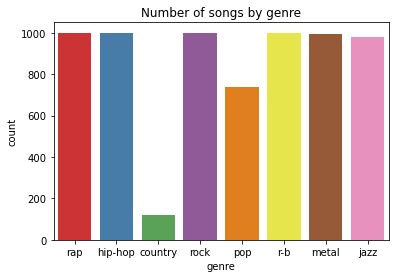

In [174]:
print("Number of songs grouped by genre of music:",data.groupby('genre').count()['lyrics'])
ax = plt.subplots()
ax = sns.countplot(x="genre", data = data, palette= "Set1")
ax.set_title("Number of songs by genre")
plt.show()

**Word clouds by genre:**

In [175]:
data_genre = data.genre.unique()

In [176]:
data_classified = []
for genre_lyrics in data_genre:
    lyrics_list = []
    for i in range(len(data.lyrics) ):
        if (data.genre[i]==genre_lyrics):
            lyrics_list.append(data.lyrics[i])
    data_classified.append(lyrics_list)

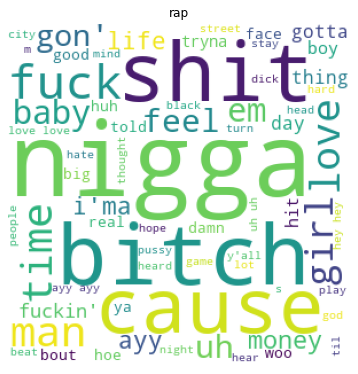

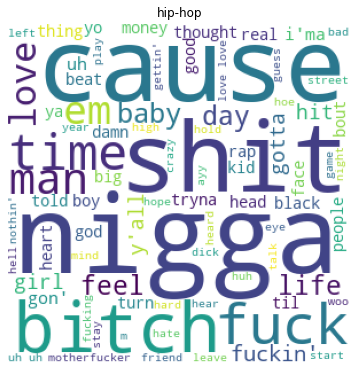

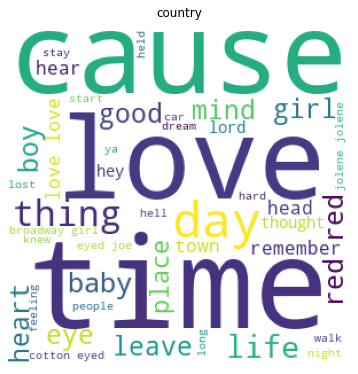

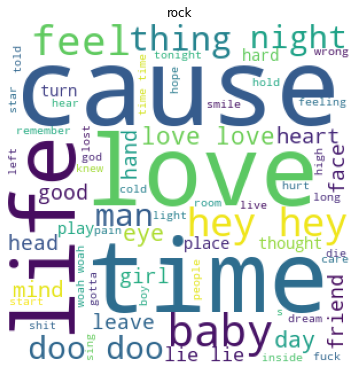

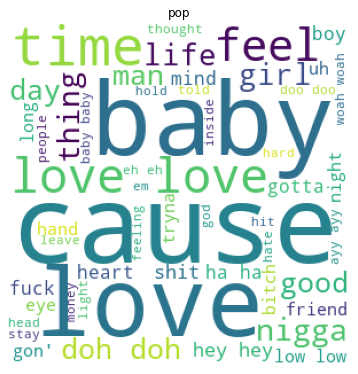

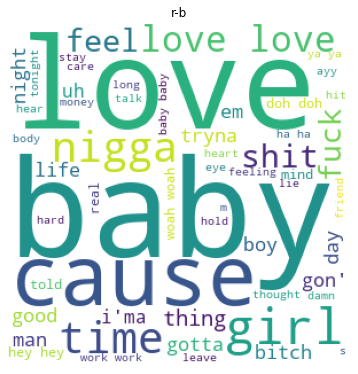

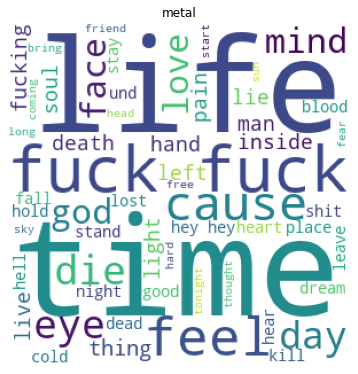

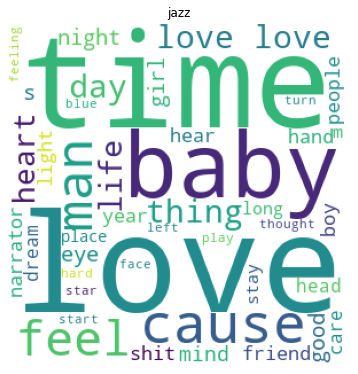

In [177]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

index_genre = 0 
#iterate through every music genre
for lyrics_of_genre in data_classified :

    wordcloud = WordCloud(width = 300, height = 300,background_color ='white', min_font_size = 10).generate(" ".join(lyrics_of_genre)+" ")
 
    # plot the WordCloud                       
    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.title(data_genre[index_genre])
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    # Save the image in the img folder:
    #wordcloud.to_file("img"+data_genre[index_genre]+"_words.png")
    index_genre +=1

### 2. DATA MODELING

#### 2.1 PREPROCESSING FOR TRAINING

In [178]:
#imports for modeling
from sklearn.model_selection import train_test_split

In [179]:
# Selecting the columns for training
y = data.genre.values
x = data.lyrics.values

In [180]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)


### 3. RESULTS